In [1]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()


11501568/11490434 [==============================] - 0s 0us/step


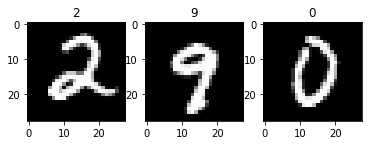

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)

# show each image, and make each title the label
# these are grayscale images so use appropriate heatmap

ax1.imshow(x_train[3333], cmap=plt.get_cmap('gray'))
ax1.set_title(str(y_train[3333]))
ax2.imshow(x_train[4589], cmap=plt.get_cmap('gray'))
ax2.set_title(str(y_train[4589]))
ax3.imshow(x_train[5498], cmap=plt.get_cmap('gray'))
ax3.set_title(str(y_train[5498]))

fig.show()

In [4]:
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1)
x_train, x_test = x_train / 255., x_test / 255

In [5]:
# Training parameters

learning_rate = 0.01
training_steps = 700
batch_size = 256
display_step = 50

In [6]:
train_data=tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_data=train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)


In [7]:
class Model:
  def __init__(self):
    self.W = tf.Variable(tf.ones([784, 10]), name="weight")
    self.b = tf.Variable(tf.zeros([10]), name="bias")

  def logistic_regression(self, x):
    return tf.nn.softmax(tf.matmul(x, self.W) + self.b)

  # cross-etropy loss function
  def loss(self, y_pred, y_true):
    # Encode label to a one hot vector
    y_true = tf.one_hot(y_true, depth=10)

    # Clip prediction values to avoid log(0) error
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    
    # Compute cross-entropy
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred),1))

  def accuracy(self, y_pred, y_true):

    # Predicted class is the index of highest score in prediction vector (i.e. argmax)
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))



In [8]:
# Stochastic gradient descent (SGD) optimizer
optimizer = tf.optimizers.SGD(lr = learning_rate)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [9]:
# perform training

def train(model, x, y):
    with tf.GradientTape() as gt:
        pred = model.logistic_regression(x)
        current_loss = model.loss(pred, y)
    
    # Compute gradients
    gradients = gt.gradient(current_loss, [model.W, model.b])

    # Update Weights and biases by following gradients
    optimizer.apply_gradients(zip(gradients, [model.W, model.b]))


In [10]:
model = Model()
losses = []
accuracy = []

# Run training for the given number of steps (training_steps)
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
  # Run the optimization to update W and b values
  train(model, batch_x, batch_y)

  if step % display_step == 0:
    pred = model.logistic_regression(batch_x)
    loss = model.loss(pred, batch_y)
    losses.append(loss)
    acc = model.accuracy(pred, batch_y)
    accuracy.append(acc)
    print(f"Step: {step}, Loss: {loss}, Accuracy: {acc}")


Step: 50, Loss: 1.8811248540878296, Accuracy: 0.71484375
Step: 100, Loss: 1.5377213954925537, Accuracy: 0.7734375
Step: 150, Loss: 1.4284124374389648, Accuracy: 0.7734375
Step: 200, Loss: 1.1812061071395874, Accuracy: 0.83203125
Step: 250, Loss: 1.0832850933074951, Accuracy: 0.81640625
Step: 300, Loss: 1.0134989023208618, Accuracy: 0.8125
Step: 350, Loss: 0.9236604571342468, Accuracy: 0.86328125
Step: 400, Loss: 0.9011346101760864, Accuracy: 0.796875
Step: 450, Loss: 0.7723303437232971, Accuracy: 0.86328125
Step: 500, Loss: 0.7755874395370483, Accuracy: 0.86328125
Step: 550, Loss: 0.7294981479644775, Accuracy: 0.8671875
Step: 600, Loss: 0.7173724174499512, Accuracy: 0.8515625
Step: 650, Loss: 0.7594597339630127, Accuracy: 0.828125
Step: 700, Loss: 0.6038872599601746, Accuracy: 0.90625


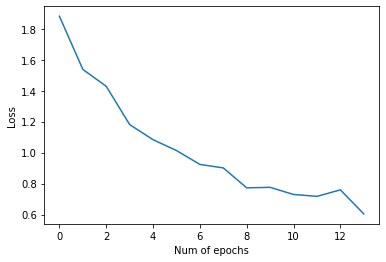

In [11]:
# Visualizing the loss function
plt.plot(losses)
plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.show()

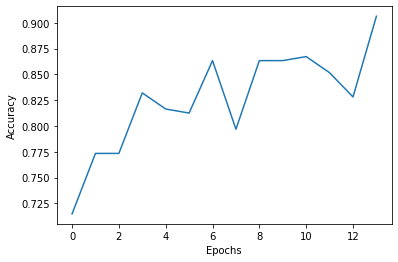

In [12]:
# Visualizing the accuracy
plt.plot(accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [13]:
# calculating the accuracy for test dataset
pred = model.logistic_regression(x_test)
print(f"Test Accuracy: {model.accuracy(pred, y_test)}")

Test Accuracy: 0.8608999848365784


In [14]:
# calculating the precision score
from sklearn.metrics import precision_score

predictions = model.logistic_regression(x_test)
class_preds = np.argmax(predictions, axis=-1)

precision_score(y_test, class_preds, average='macro')

0.8611980469990244

In [15]:
# calculating the recall score
from sklearn.metrics import recall_score

recall_score(y_test, class_preds, average='macro')

0.8581637386812473